# ROCK PAPER SCISSOR RECOGNIZER USING CNN

# **PREPROCESSING DATA** 

* Get Data From Folder
* read the data
* Convert to YCRCBA and get luminance valu from image
* thresholding to make binary image
* normalising pixel image
* add them to new list

In [2]:
import os
import cv2
import numpy as np
def gather_data(x):
    kum=[]
    y=[]
    base="/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/test"
    kelas=os.listdir(base)
    for i in kelas:
        direktori=f"/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/{x}/{i}"
        for j,k,l in os.walk(direktori):
            for m in l:
                if m.endswith('.png'):
                    im=cv2.imread(os.path.join(j,m))
                    #convert to gray
                    yrcb_image=cv2.cvtColor(im,cv2.COLOR_BGR2YCrCb)                   
                    #piksel more than 250 convert to 255, and pixel less than 250 convert to 0
                    luminance=yrcb_image[:,:,0]
                    thresh_value,thresh_img=cv2.threshold(luminance,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                    #define kernel size ukuran filter
                    kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
                    #menutupi lubang pada object
                    tr_image=cv2.morphologyEx(thresh_img,cv2.MORPH_CLOSE,kernel,iterations=2)
                    gam=np.array(~tr_image)
                    y.append(i)
                    kum.append(gam)  
    return kum,y,kelas

['paper', 'rock', 'scissors']


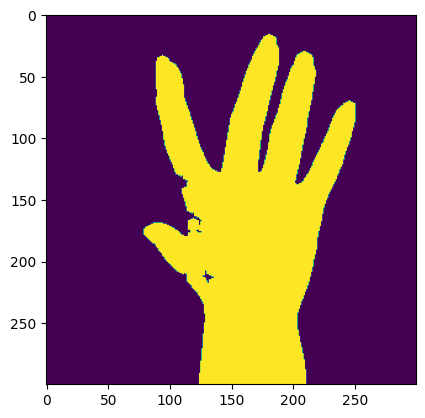

In [3]:
train_data,ytrain,k=gather_data('train')
train_val,yval,l=gather_data('test')
from matplotlib import pyplot as plt
plt.imshow(train_data[0])
print(k)

**Transform variabel y to numerical value** when class image is paper, we change to 0, and rock is 1, and scissors is 2

In [4]:
def convert_num(x):
    if x =='paper':
        return 0
    elif x=="rock":
        return 1
    else:
        return 2
y_num=list(map(convert_num,ytrain))
from tensorflow.keras.utils import to_categorical
y_cat=to_categorical(y_num)
yval_num=list(map(convert_num,yval))
yval_cat=to_categorical(yval_num)
y_cat[0]

array([1., 0., 0.])

**Normalization to 0-1**

In [5]:
def normalization(x):
    res=x/255
    return res
norm_train=list(map(normalization,train_data))
norm_val=list(map(normalization,train_val))
import numpy as np
arr_tr=np.array(norm_train)
arr_val=np.array(norm_val)

print(f"The dimensian of training set is {arr_tr.shape}")
print(f"The dimensian of validation set is {arr_val.shape}")


The dimensian of training set is (2520, 300, 300)
The dimensian of validation set is (372, 300, 300)


based on result above, the validation set is not 20% of  total data so we must add random data to achieve 20% of the data

In [6]:
#add random image from training
less=((20/100)*len(ytrain))-len(yval)
li=[]
y_li=[]
ind=[]
while len(li)<less:
    rand=np.random.randint(1,2520)
    ambil=arr_tr[rand]
    y_li.append(y_cat[rand])
    li.append(ambil)
    ind.append(rand)
#gabung
arr_val_new=np.concatenate((arr_val, np.array(li)))
yval_cat_new=np.concatenate((yval_cat,np.array(y_li)))
#delete
arr_tr_new=np.delete(arr_tr,ind,axis=0)   
y_cat_new=np.delete(y_cat,ind,axis=0)           
print(y_cat_new.shape)
print(arr_tr_new.shape)
print(arr_val_new.shape)
print(yval_cat_new.shape)

(2391, 3)
(2391, 300, 300)
(504, 300, 300)
(504, 3)


**Build The Model** : using convolutional neural network

In [7]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(300,300,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 298, 298, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 147, 147, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 73, 73, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 341056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      21,827,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,846,659 (83.34 MB)

 Trainable params: 21,846,659 (83.34 MB)

 Non-trainable params: 0 (0.00 B)

**Compile the model**

In [9]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**train the model**

In [10]:
train_mod=model.fit(arr_tr_new,y_cat_new,epochs=10,batch_size=32,validation_data=(arr_val_new,yval_cat_new))

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - accuracy: 0.6726 - loss: 1.3817 - val_accuracy: 0.8294 - val_loss: 0.4632
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9889 - loss: 0.0379 - val_accuracy: 0.8333 - val_loss: 0.5853
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9963 - loss: 0.0114 - val_accuracy: 0.8313 - val_loss: 0.6181
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9945 - loss: 0.0114 - val_accuracy: 0.8413 - val_loss: 0.6181
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9984 - loss: 0.0041 - val_accuracy: 0.8234 - val_loss: 0.9234
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9987 - loss: 0.0055 - val_accuracy: 0.7937 - val_loss: 0.9067
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9983 - loss: 0.0106 - val_accuracy: 0.7837 - val_loss: 0.8656
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9999 - loss: 0.0027 - val_accuracy: 0.8234 -

**Evaluate model performances**

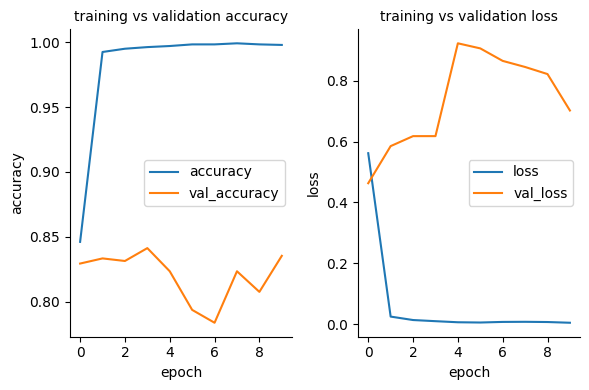

In [11]:
from matplotlib import pyplot as plt
metrik=[['accuracy','val_accuracy'],['loss','val_loss']]
fig,ax=plt.subplots(1,2,figsize=(6,4))
names=['accuracy','loss']
for i,j,l in zip(ax,metrik,names):
    for k in j:
        i.plot(train_mod.history[k],label=k)
        i.set_title(f'training vs validation {l}',fontsize=10)
        i.set_xlabel('epoch')
        i.set_ylabel(l)

        i.spines['top'].set_visible(False)
        i.spines['right'].set_visible(False)
        i.legend()
plt.tight_layout()

- the model is overfitting work poorly on validation dataset

# **data augmentation** :

**is like add diversity od random data by applying transformation like fli, rotation, zoom, shift**

****reshape input model**** : from (a,b,c) to (a,b,c,d). the d is channel we used, because we used biner image the channel is 1 and if we use RGB the channel is 3

In [12]:
arr_tr_rs=arr_tr_new[...,np.newaxis]
arr_val_rs=arr_val_new[...,np.newaxis]


**data augmentation for validation and training dataset**

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#define rule of augmentation
aug_rule=ImageDataGenerator(
    rotation_range=45,
    height_shift_range=0.2,
    width_shift_range=0.2,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'

)

#make a batch of data augmentation
train_aug=aug_rule.flow(
    arr_tr_rs,
    y_cat_new,
    batch_size=64,
)
val_aug=aug_rule.flow(
    arr_val_rs,
    yval_cat_new,
    batch_size=32,
)

**make new model**

In [14]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
model_1=Sequential()
model_1.add(Conv2D(32,(3,3),activation='relu',input_shape=(300,300,1)))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32,(3,3),activation='relu'))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32,(5,5),activation='relu'))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32,(3,3),activation='relu'))
model_1.add(Flatten())
model_1.add(Dense(64,activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(3,activation='softmax'))

In [15]:
model_1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 298, 298, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 149, 149, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 147, 147, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 73, 73, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 69, 69, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 34, 34, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,141,859 (8.17 MB)

 Trainable params: 2,141,859 (8.17 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model_1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

**fit the model using new dataset**

In [17]:
train_aug_mod=model_1.fit(train_aug,epochs=15,batch_size=32,validation_data=val_aug)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


38/38 ━━━━━━━━━━━━━━━━━━━━ 28s 469ms/step - accuracy: 0.4048 - loss: 1.0775 - val_accuracy: 0.5516 - val_loss: 0.8828
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 0.6288 - loss: 0.8011 - val_accuracy: 0.8254 - val_loss: 0.5000
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - accuracy: 0.8358 - loss: 0.4453 - val_accuracy: 0.8571 - val_loss: 0.3912
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 349ms/step - accuracy: 0.8412 - loss: 0.4232 - val_accuracy: 0.9008 - val_loss: 0.2895
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 357ms/step - accuracy: 0.8946 - loss: 0.2825 - val_accuracy: 0.8631 - val_loss: 0.3651
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 348ms/step - accuracy: 0.9017 - loss: 0.2872 - val_accuracy: 0.8889 - val_loss: 0.2901
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - accuracy: 0.9265 - loss: 0.2104 - val_accuracy: 0.8413 - val_loss: 0.5355
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 354ms/step - accuracy: 0.9204 - loss: 0.2269 - val_accuracy: 0.871

**evaluate model performances**

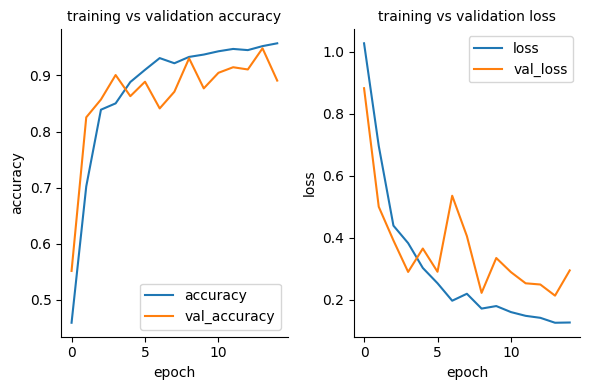

In [18]:
from matplotlib import pyplot as plt
metrik=[['accuracy','val_accuracy'],['loss','val_loss']]
fig,ax=plt.subplots(1,2,figsize=(6,4))
names=['accuracy','loss']
for i,j,l in zip(ax,metrik,names):
    for k in j:
        i.plot(train_aug_mod.history[k],label=k)
        i.set_title(f'training vs validation {l}',fontsize=10)
        i.set_xlabel('epoch')
        i.set_ylabel(l)

        i.spines['top'].set_visible(False)
        i.spines['right'].set_visible(False)
        i.legend()
plt.tight_layout()

based on the result, the model_1 is works well for both validation and training dataset

# **Test the model**

**get test dataset**

In [19]:
test=[]
ytest=[]
dir_test="/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/validation"
for j,k,l in os.walk(dir_test):
    for m in l:
        if m.endswith('png'):
            im=cv2.imread(os.path.join(j,m))
            #when the size is more than 300 for both x and y:
            if im.shape[0] >300 and im.shape[1]>300:
                resize=cv2.resize(im,(300,300))
                yrcb_image=cv2.cvtColor(resize,cv2.COLOR_BGR2YCrCb)
            else :
                yrcb_image=cv2.cvtColor(im,cv2.COLOR_BGR2YCrCb)                   

                         
            #piksel more than 250 convert to 255, and pixel less than 250 convert to 0
            luminance=yrcb_image[:,:,0]
            thresh_value,thresh_img=cv2.threshold(luminance,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            #define kernel size ukuran filter
            kernel=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
            #menutupi lubang pada object
            tr_image=cv2.morphologyEx(thresh_img,cv2.MORPH_CLOSE,kernel,iterations=2)
            gam=np.array(~tr_image)
            
            test.append(gam)  
test_norm=list(map(normalization,test))

**important task we need to resize image when not we wanted**

33


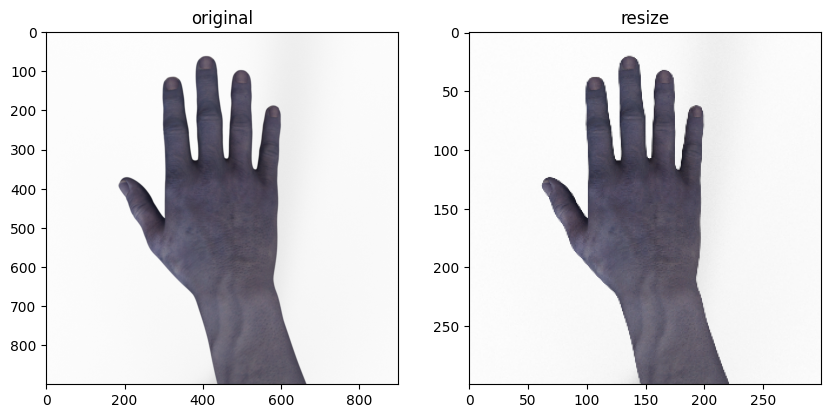

In [44]:
from matplotlib import pyplot as plt
dir_test="/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/validation"
tst_data=[]
namefile=[]
for j,k,l in os.walk(dir_test):
    for m in l:
         if m.endswith('png'):
             im=cv2.imread(os.path.join(j,m))
             tst_data.append(im)
             namefile.append(m)
#there're 900 x 900 we need resize
fig,ax=plt.subplots(1,2,figsize=(10,10))
im=cv2.imread("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/validation/paper-hires2.png")

for i in range(2):
    if i ==0:
        ax[i].imshow(im)
        ax[i].set_title('original')
    else:
        resize=cv2.resize(im,(300,300))
        ax[i].imshow(resize)
        ax[i].set_title('resize')
print(len(tst_data))


        


**predict the data using model**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


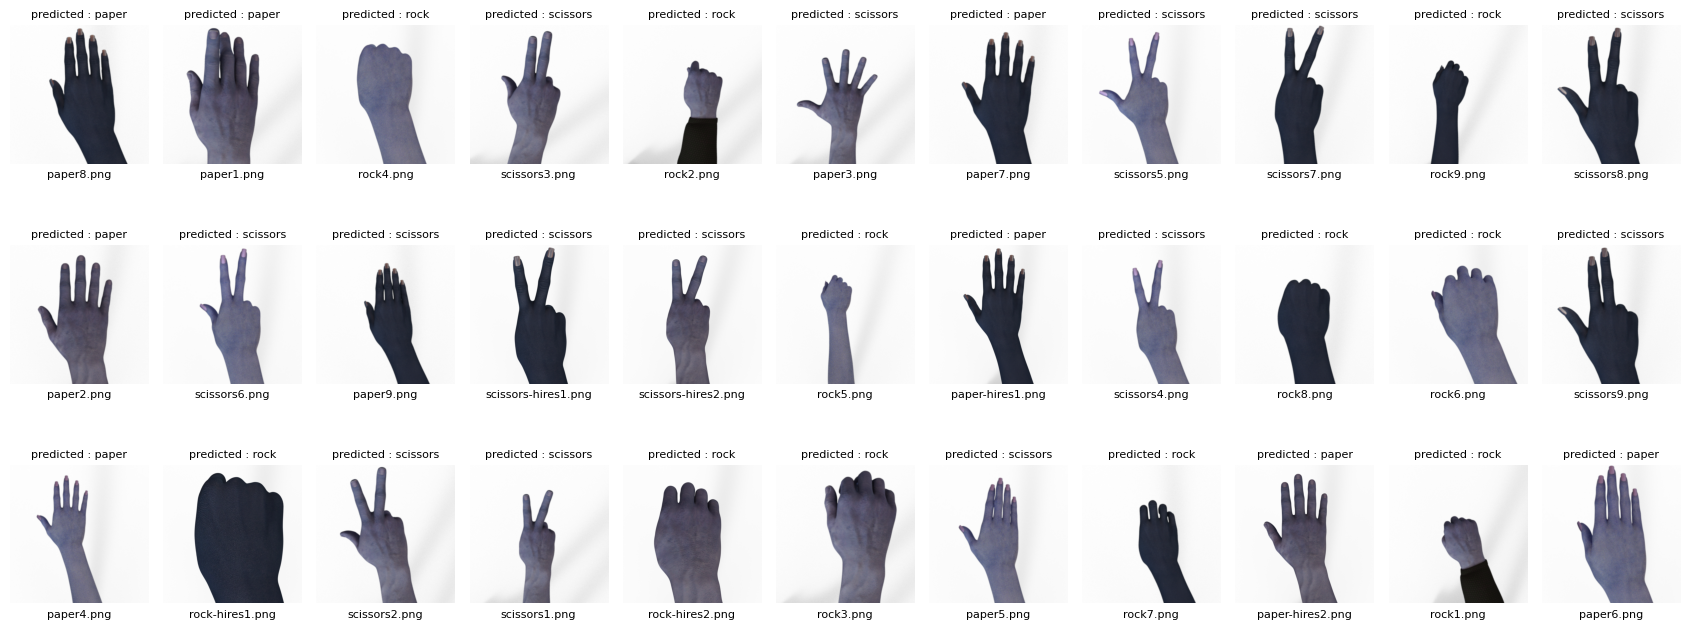

In [54]:
arr_norm=np.array(test_norm).reshape(-1,300,300,1)
predict=model_1.predict(arr_norm)
predict_class=np.argmax(predict,axis=1)
def kelas(x):
    if x==0:
        return 'paper'
    elif x==1:
        return 'rock'
    else:
        return 'scissors'
result_class=list(map(kelas,predict_class))
#show the result
fig,ax=plt.subplots(3,11,figsize=(17,7))
for (i,j),k,l,m in zip ([(i,j) for i in range (3) for j in range(11)],tst_data,result_class,namefile):
    ax[i][j].imshow(k)
    ax[i][j].set_title(f"predicted : {l}",fontsize=8)
    ax[i][j].axis('on')
    ax[i][j].spines['bottom'].set_visible(False)
    ax[i][j].spines['top'].set_visible(False)
    ax[i][j].spines['left'].set_visible(False)
    ax[i][j].spines['right'].set_visible(False)

    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])


    ax[i][j].set_xlabel(f"{m}",fontsize=8)
plt.tight_layout()

based on the result preducting the test dataset, we correct 30 image predicted and only two is worng, the accuracy is 30/32= 93.75%